# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import scipy.stats as stats


from sklearn import set_config


from sklearn.datasets import load_iris,load_breast_cancer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc 


# Intro

This notebook provides notes for common classes and methods used in scikit-learn. It also answers questions to concepts I had trouble understanding. 

In [2]:
X, y = load_iris(return_X_y=True, as_frame=True)
rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
print(X.shape)
print(X_train.shape)

(150, 4)
(120, 4)


## Estimators

**Definition:** An estimator is any object in scikit-learn that learns from data by calling `fit()`.

*   It can be a transformer (e.g., `StandardScaler`), a predictor (e.g., `LogisticRegression`), or both.
*   Essentially, if an object has a `fit()` method, it's an estimator.

In [3]:
scaler = StandardScaler()  # Estimator
model = LogisticRegression()  # Estimator

scaler.fit(X_train)  # ✅ Works because StandardScaler is an estimator
model.fit(X_train, y_train)  # ✅ Works because LogisticRegression is an estimator

LogisticRegression()

### Transformer

**Definition:** A transformer is a special type of estimator that modifies data by calling `transform()`.

*   Transformers are used for preprocessing (scaling, encoding, feature selection, etc.).
*   They learn something from `fit()` and apply it with `transform()`.
*   Many transformers also support `fit_transform()` to do both in one step.

In [4]:
scaler = StandardScaler()
encoder = OneHotEncoder()
pca = PCA(n_components=2)

scaler.fit(X_train)  # ✅ Learns mean & std
X_scaled = scaler.transform(X_train)  # ✅ Applies scaling

X_scaled = scaler.fit_transform(X_train)  # ✅ Shortcut (fit + transform)

pca.fit(X_train)  # ✅ Learns principal components
X_pca = pca.transform(X_train)  # ✅ Applies dimensionality reduction
X_pca = pca.fit_transform(X_train)  # ✅ Shortcut (fit + transform)

**Rule:** If an object has both `fit()` and `transform()`, it's a transformer.

### Predictor

**Definition:** A predictor is an estimator that makes predictions by calling `predict()`.

*   Predictors are models that take input data and output predictions.
*   Some predictors also support `predict_proba()` for probability estimates.

In [5]:
clf = LogisticRegression()  # Predictor
rf = RandomForestClassifier()  # Predictor

clf.fit(X_train, y_train)  # ✅ Learns from data
y_pred = clf.predict(X_test)  # ✅ Makes predictions

rf.fit(X_train, y_train)  # ✅ Learns from data
y_prob = rf.predict_proba(X_test)  # ✅ Outputs class probabilities


**Rule:** If an object has `predict()`, it's a predictor.

# Pipeline

In [6]:
# X, y = load_digits(return_X_y=True)
# df = pd.DataFrame(X)
# df['target_digit'] = y


rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rng)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

duplicates = [np.any(np.all(row == X_train, axis=1)) for row in X_test]
print(np.any(duplicates))  # Should be False


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(random_state=rng))
])

param_grid = [
    {'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__alpha': [0.0001, 0.00003, 0.00005, 0.00007]}
]

# pipe.fit(X_train, y_train)
# # training set
# y_pred_train = pipe.predict(X_train)
# y_pred_train_score = classification_report(y_train, y_pred_train) 
# # test set
# y_pred = pipe.predict(X_test)
# y_score = classification_report(y_test, y_pred)
# print(f"Score on train set:\n{y_pred_train_score}\n\nScore on test data\n{y_score}")
grid = GridSearchCV(pipe, param_grid=param_grid, cv=30, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"\nBest Estimator:\n{grid.best_estimator_}\nBest Params:\n{grid.best_params_} \nBest score:\n{grid.best_score_}\n\nCV Results\n\n{pd.DataFrame(grid.cv_results_)}")


(120, 4) (30, 4)
(120,) (30,)
False

Best Estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SGDClassifier(alpha=7e-05, penalty='l1',
                               random_state=RandomState(MT19937) at 0x1D76F30BD40))])
Best Params:
{'model__alpha': 7e-05, 'model__penalty': 'l1'} 
Best score:
0.95

CV Results

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.006955      0.007727         0.003085        0.005898   
1        0.004918      0.006926         0.001309        0.003930   
2        0.004758      0.006889         0.001726        0.004441   
3        0.005086      0.006218         0.001184        0.003158   
4        0.001949      0.003662         0.001594        0.003969   
5        0.002191      0.005313         0.000059        0.000287   
6        0.003571      0.006477         0.001067        0.003744   
7        0.004544      0.007404         0.001104        0.003908   
8        0.003919      0.00

In [7]:

y_pred = grid.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.93      1.00      0.96        13
           2       1.00      0.83      0.91         6

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97        30



In [8]:
cv_score = cross_val_score(grid.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
print(cv_score)
print('\nAvg accuracy: \n', cv_score.mean())

[0.875      0.95833333 0.91666667 1.         0.79166667]

Avg accuracy: 
 0.9083333333333334


### Pipeline Questions

#### Pipeline Order
**Question**: So when predictions = `pipe.predict(X_test)` is called, is it taking the scaler into account?
- Yes! ✅ When you call: predictions = pipe.predict(X_test), the entire pipeline is applied, meaning both the scaler and the classifier are used.

When you call `pipe.predict(X_test)`, the pipeline follows these steps in order:

1.  **`StandardScaler` transforms `X_test`:**
    The raw test data (`X_test`) is scaled using the `MinMaxScaler` that was already fitted on `X_train`.

2.  **`SGDClassifier` makes predictions on the scaled data:**
    The classifier (`SGDClassifier`) receives the transformed data and makes predictions.
    


# GridSearchCV

### GridSearchCV Questions

#### Param Grid Syntax
syntax is :

*estimator*__*parameter* (estimator, two underscores, parameter)

**Question**: What is the difference (using above pipeline's example) between

```
param_grid = [
    {'model__penalty': ['l2', 'l1', 'elasticnet']},
    {'model__alpha': [0.0001, 0.001, 0.01, 0.1]}
]
```

and

```
param_grid = {
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1]
}

```



In [9]:

# this has TWO different grids (there is a list of dictionaries)
param_grid = [
    {'model__penalty': ['l2', 'l1', 'elasticnet']}, #grid 1
    {'model__alpha': [0.0001, 0.001, 0.01, 0.1]} #grid 2
]

# this is ONE grid (one dictionary)
param_grid = {
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__alpha': [0.0001, 0.001, 0.01, 0.1]
}


The **first** param_grid will **NOT** consider all combinations of `penalty` and `alpha`, `GridSearchCV` treats them as two separate independent grids.

It will:

- 1. Try tuning only `model__penalty` while keeping the default value for `model__alpha` (which is 0.0001).
- 2. Then, it will try tuning only `model__alpha` while keeping the default value for `model__penalty` (which is 'l2').

The **second** param_grid will **WILL** consider all combinations of `penalty` and `alpha`, `GridSearchCV` treats them as one grid.


# Column Transformer

# SimpleImputer

Replaces NaNs with a strategy like mean, median, mode, or a constant.

In [10]:
from sklearn.impute import SimpleImputer
import numpy as np

X_2 = np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]])
imputer = SimpleImputer(strategy="mean")  # Replace NaNs with column mean
X_imputed = imputer.fit_transform(X_2)
X_imputed

array([[1. , 2. , 7.5],
       [4. , 5. , 6. ],
       [7. , 8. , 9. ]])

# IterativeImputer

Estimates missing values by predicting them based on other features.

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
X_imputed = imputer.fit_transform(X_2)
X_imputed

array([[1.        , 2.        , 3.00203274],
       [4.        , 4.99796925, 6.        ],
       [7.        , 8.        , 9.        ]])

# Feature Selection

## Filter Methods

### Variance Threshold

The *VarianceThreshold* in scikit-learn is a simple baseline *filter method* for feature selection. It removes features that have low variance — meaning features that don't change much across samples.
- If a feature has the same value (or nearly the same value) for all samples, it doesn’t provide useful information to the model.
Such features don’t help in distinguishing between classes or predicting targets, so removing them can simplify the model without losing performance.

- Such features don’t help in distinguishing between classes or predicting targets, so removing them can simplify the model without losing performance.

In [12]:
from sklearn.feature_selection import VarianceThreshold

# Initialize with a threshold — features with variance below this will be removed
selector = VarianceThreshold(threshold=0.01)

# Fit and transform the data
X_filtered = selector.fit_transform(X)

# To check variances of all features
print(selector.variances_)


[0.68112222 0.18871289 3.09550267 0.57713289]


- *Threshold* = 0 (default): Removes features with zero variance (constant features).
- Higher thresholds: Remove features with variance lower than the given value.

### Mutual Information

Scikit-learn’s `mutual_info_classif` and `mutual_info_regression` are *filter methods* and measure how much information each feature contributes to predicting the target:

In [13]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information scores
mi_scores = mutual_info_classif(X, y)

# Convert to DataFrame for easy viewing
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
print(mi_df.sort_values(by='MI Score', ascending=False))

# Keep features above a threshold
threshold = 0.05  # Adjust based on your dataset
selected_features = X.columns[mi_scores > threshold]
print("Features selected by mutual information:", selected_features.tolist())


             Feature  MI Score
2  petal length (cm)  0.998017
3   petal width (cm)  0.983198
0  sepal length (cm)  0.499322
1   sepal width (cm)  0.236772
Features selected by mutual information: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Chi-Square Test (chi2)

- Purpose: Tests the independence of categorical variables by comparing observed and expected frequencies.
- Use Case: When you have categorical features and want to test their dependence on the target (often used for classification).

In [14]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=2)  # Select the top 5 features
X_selected = selector.fit_transform(X, y)
X_selected[:5]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

### ANOVA F-Test (f_classif)

- Purpose: Performs a statistical test to determine the relationship between each feature and the target variable (for classification tasks).
- Use Case: When you want to assess the strength of the relationship between each feature and the target, particularly in classification tasks.

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=2)  # Select the top 2 features based on F-test
X_selected = selector.fit_transform(X, y)
X_selected[:5]


array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

### SelectFromModel

 - Purpose: Selects features based on the importance values derived from a fitted model. This is model-dependent, so it works only after training a model that assigns feature importances (e.g., decision trees, Lasso).

In [16]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y)
selector = SelectFromModel(model, threshold="mean")  # Select features above mean importance
X_selected = selector.transform(X)


c:\Users\Diego\Documents\Coding\.venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


### SelectKBest (general Selection)

Purpose: Selects the top k features based on a given scoring function (e.g., chi2, f_classif, etc.). It's a general-purpose feature selection method.

### Summary

- VarianceThreshold: Removes low-variance features.
- Mutual Information: Measures how much information a feature shares with the target.
- Chi-Square Test: Evaluates dependence for categorical data.
- ANOVA F-Test: Tests the relationship between features and the target for classification tasks.

| **Method**           | **Description**                                                    | **Use Case**                                                                                                                                                                |
|----------------------|--------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **VarianceThreshold** | Removes features with low variance.                                | **Use when**: You want to remove features that don't vary much across the dataset, such as constant or near-constant features. Features with very low variance often don’t carry significant information, and removing them can reduce noise. For example, in a dataset where many rows have the same value for a feature (e.g., a feature indicating gender where 99% of entries are male), this feature won't help in prediction and can be discarded. |
| **Mutual Information**| Measures how much information each feature shares with the target. | **Use when**: You **expect a non-linear relationship** between features and the target. Mutual information captures more complex, non-linear interactions that may not be apparent in linear models. For example, in tasks like image classification or predicting customer churn, there may be complex dependencies between features (e.g., user behavior patterns) and the target (e.g., whether the customer churns or not). Mutual information can uncover those patterns even when they are non-linear. |
| **Chi-Square Test**   | Evaluates dependence for categorical data.                         | **Use when**: Your **data is categorical and you're working on a classification** task. This test is useful for determining if any of your categorical features are independent of the target variable. For example, in a dataset of customer survey responses where the target variable is "Product Purchased" (a categorical target), you can use the Chi-Square test to assess the dependence between each feature (e.g., age group, income level) and the target. It helps you focus on features that are more likely to influence the target. |
| **ANOVA F-Test**      | Tests the relationship between features and the target variable (classification). | **Use when**: Your **target is categorical and your features are continuous**. The ANOVA F-test is used to determine whether the means of different groups (based on the target classes) are statistically different from each other. For example, in a dataset predicting income categories (low, medium, high), and using continuous features such as years of education and job experience, the ANOVA F-test helps identify which features vary significantly across the income categories. |
| **SelectFromModel**   | Selects features based on model feature importance after fitting a model. | **Use when**: You have a trained model that computes feature importance (such as a decision tree, random forest, or Lasso regression). After fitting the model, SelectFromModel allows you to select the most important features as determined by the model’s internal mechanism. This method is particularly useful when you want feature selection to align directly with the model’s learning, improving efficiency by focusing on features most relevant to the target. For example, in a random forest model predicting loan default, features like "credit score" and "loan amount" might be identified as most important. |
| **SelectKBest**       | Selects the top k features based on a scoring function (e.g., F-test, Chi-Square, etc.). | **Use when**: You want to select the top **k** features based on a specific scoring function. This is ideal when you have a large set of features and need a fixed number of the most relevant ones. It works well when you're aiming to reduce the dimensionality of the data while keeping the most informative features. For example, when you have a dataset with hundreds of features, SelectKBest can help you choose the 5 most important features based on their relationship with the target (e.g., using the F-test or Chi-Square test). |
| **SelectPercentile**  | Selects a specified percentile of features based on a scoring function. | **Use when**: You want to select a specified proportion (percentile) of features instead of a fixed number. This method is useful when you don't want to predefine the exact number of features to keep, but rather the percentage of the best features based on their importance score. For example, in a dataset with thousands of features, you might want to keep the top 10% of features, which are the most strongly correlated with the target variable. |


## Handling Multicollinearity

### Maybe Best Way - Pandas Correlation Matrix

df.corr() is a *filter method*. If two features have a correlation above a threshold (e.g., 0.9), drop one of them.

In [17]:
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with high correlation
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop highly correlated features
df_reduced = X.drop(to_drop, axis=1)
print(X.shape)
print(df_reduced.shape)


(150, 4)
(150, 3)


### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) reduces redundancy by transforming correlated features into a set of uncorrelated components.


**1. To Reduce the Number of Features (Dimensionality Reduction)**

*   If your dataset has many features (high dimensionality), PCA can help reduce the number while keeping most of the information.
*   This is useful because high-dimensional data can lead to the curse of dimensionality, making models slower and more prone to overfitting.
*   **📌 Use case:** You have a dataset with hundreds of features, but many are redundant or correlated. PCA helps compress the data.

**2. To Handle Multicollinearity (Highly Correlated Features)**

*   If features are highly correlated, models like linear regression and logistic regression may struggle.
*   PCA creates new uncorrelated features (principal components), which can improve model performance.
*   **📌 Use case:** You have a dataset with many correlated variables (e.g., stock prices, sensor data). PCA helps remove redundancy.

**3. To Speed Up Training for Computational Efficiency**

*   Some machine learning models (e.g., SVMs, k-NN) slow down with too many features.
*   Reducing dimensions with PCA can make training and predictions faster.
*   **📌 Use case:** You're working with image data (e.g., 64x64 pixels = 4,096 features per image). Reducing dimensions with PCA speeds up training.

**4. To Visualize High-Dimensional Data**

*   PCA can reduce a dataset from many dimensions to 2D or 3D, making it easier to plot and visualize patterns.
*   This is often used in exploratory data analysis (EDA).
*   **📌 Use case:** You want to visualize customer clusters in a 100-feature dataset. PCA helps reduce it to 2D for plotting.

**5. To Denoise Data (Feature Compression)**

*   PCA helps filter out small variations or noise by focusing on the most important components.
*   It can be useful for image compression or removing noise from sensor data.
*   **📌 Use case:** You're working with speech recognition or ECG signals with lots of noise. PCA helps keep only useful information.

**When Should You NOT Use PCA?**

*   **❌ When feature interpretability is important** – PCA transforms features into abstract components that are harder to interpret.
*   **❌ When you have categorical features** – PCA only works with numerical data.
*   **❌ When your model already handles correlated features well** – Some algorithms (e.g., tree-based models like Random Forests) don't need PCA.

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduce to 2 components

print('X Train Shape')
print(X_train.shape)

X_pca = pca.fit_transform(X_train)

print('\nPCA')
print(X_pca)

print('\nPCA Shape')
print(X_pca.shape)

X Train Shape
(120, 4)

PCA
[[ 1.83108424  0.01487935]
 [ 0.508027   -0.49990539]
 [-2.63234419  0.39631447]
 [ 1.2154392  -0.14342924]
 [ 2.08221549 -0.25701398]
 [-0.09269602 -0.73118799]
 [-2.26284668  0.89603188]
 [ 1.29859689 -0.44790598]
 [ 0.43577911 -0.11974613]
 [ 0.14836036 -0.41564899]
 [ 2.09364846  0.17637486]
 [-2.96574461 -0.11186675]
 [ 1.85392326  0.3710556 ]
 [-2.47613637  0.21406273]
 [-2.57299467  0.672843  ]
 [-0.60245412 -1.2666873 ]
 [ 1.87498856  0.00667557]
 [ 2.3507      0.26051941]
 [ 1.21267519 -0.78727627]
 [ 2.24033716 -0.28444214]
 [-0.03959956 -0.59214366]
 [ 3.00933971  0.63470325]
 [ 1.02468268  0.25993297]
 [-0.15467285 -0.71207189]
 [ 1.31036263 -0.23307084]
 [ 1.36575364 -0.17111743]
 [ 0.4318474  -1.20815433]
 [ 1.44608782 -0.40633872]
 [ 1.21713007  0.65883824]
 [ 1.69098714  0.04475602]
 [ 0.73640221  0.17474832]
 [-2.66564468 -0.1750786 ]
 [ 1.33330908 -0.60335789]
 [ 0.27456065 -0.5176113 ]
 [-0.25206012 -0.26112711]
 [ 0.08120361 -0.69243754]


### Pandas vs PCA

| Method                                      | When to Use                                                                                                | Pros                                                                                                  | Cons                                                                                                               |
| :------------------------------------------ | :--------------------------------------------------------------------------------------------------------- | :---------------------------------------------------------------------------------------------------- | :----------------------------------------------------------------------------------------------------------------- |
| Pandas Correlation Matrix (Feature Dropping) | When you have redundant features that don't add much value.                                              | - Keeps interpretability (e.g., in regression models).<br> - Simple to implement.                       | - May remove useful features.<br> - Manual threshold selection (e.g., >0.9 correlation).                       |
| PCA (Principal Component Analysis)         | When you want to reduce dimensionality but keep all information.                                            | - Keeps all data (just transforms it).<br> - Helps avoid multicollinearity.                           | - Harder to interpret (new features are combinations of old ones).<br> - Might lose small but important details. |

**When to Use What?**

*   **For regression models (like Linear Regression, Logistic Regression)** → Use the correlation matrix to drop features (because collinearity causes unstable coefficients).
*   **For machine learning models like SVM, Random Forest, or Neural Networks** → PCA can be useful (since models don't require interpretability, and PCA can improve efficiency).
*   **If you need high interpretability** → Feature dropping is better.
*   **If dimensionality is too high and you don't care about feature meaning** → Use PCA.

**Conclusion**

*   If you can afford to lose features, drop them using pandas correlation matrix.
*   If you want to keep all information, use PCA, but be aware that transformed features are no longer in the original space.

### Using Regularization

Use the estimator's built in Regularization / C / Penalty / Alpha .. etc parameter to adjust the Regularization. 

- Lasso Regression (L1 penalty) can shrink some feature coefficients to zero, effectively removing redundant ones.
- Ridge Regression (L2 penalty) penalizes large coefficients, reducing their impact but not removing them completely.

## Feature Selection Table

| Name (Library & Syntax)                                                                     | Description                                                                                                                                                                                                                                                         | When to Use                                                                                                                                                           |
| :---------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Variance Threshold** (sklearn.feature_selection) <br> `VarianceThreshold(threshold=0.1)`  | Removes features with low variance.  It assumes that features with little variation across samples don't contribute much information to the model. It operates solely on the feature itself, not its relationship with the target variable.                               | - **High-dimensional data:** When you have many features, and you suspect many are constant or nearly constant. <br> - **Unsupervised learning:**  Useful as a first, simple filter since it doesn't require a target variable. <br> - **Preprocessing:** To remove obviously uninformative features before applying more complex methods.  |
| **2. Mutual Information** (sklearn.feature_selection) <br> `mutual_info_classif(X, y)` (for classification) <br> `mutual_info_regression(X, y)` (for regression) | Measures the dependency between a feature and the target variable. Higher mutual information means a stronger relationship (linear or non-linear).  Captures non-linear relationships, unlike correlation.                                                                 | - **Non-linear relationships:** When you suspect features might have non-linear relationships with the target. <br> - **Classification & Regression:** Applicable to both. <br> - **Discrete target variables:** More naturally suited to classification (discrete targets), but can be used with regression by discretizing the target. |
| **3. Correlation (df.corr())** (pandas) <br> `df.corr()`                                       | Calculates the Pearson correlation coefficient between each feature and the target variable (or between features themselves).  Measures *linear* relationships only.  Positive correlation means features increase/decrease together; negative means they vary inversely.   | - **Linear relationships:** When you expect a linear relationship between features and the target. <br> - **Regression:** Most directly applicable to regression problems. <br> - **Multicollinearity Detection:**  `df.corr()` applied to the features (not just the target) helps identify highly correlated features (multicollinearity), which can be problematic for some models (like linear regression).  You might remove one of a pair of highly correlated features. |
| **4. Principal Component Analysis (PCA)** (sklearn.decomposition) <br> `PCA(n_components=k)` | A dimensionality reduction technique, *not strictly a feature selection method*, but often used in a similar way.  PCA transforms the original features into a new set of uncorrelated features (principal components) ordered by the amount of variance they explain. You can then select a subset of the top components. | - **Dimensionality reduction:** When you need to reduce the number of features while retaining as much variance as possible.  <br> - **Multicollinearity:**  PCA inherently handles multicollinearity by creating uncorrelated components. <br> - **Visualization:** Can be used to visualize high-dimensional data in 2D or 3D. <br> - **Noise reduction:** By keeping only the top components, you often filter out noise. <br> **Important:** PCA *transforms* features, it doesn't select the original ones. |
| **5. Recursive Feature Elimination with Cross-Validation (RFECV)** (sklearn.feature_selection) <br> `RFECV(estimator, step=1, cv=5)` | Iteratively removes features and builds a model, using cross-validation to evaluate performance at each step. Selects the feature subset that yields the best cross-validation score.  Uses a model's internal feature importance (if available) or coefficients.     | - **Model-specific feature selection:** When you have a specific model in mind and want to find the best features *for that model*. <br> - **Automated process:** Automates the iterative feature elimination process. <br> - **Robustness:** Cross-validation makes the selection more robust to overfitting. <br> - **Computational cost:** Can be computationally expensive, especially with many features. |
| **6. Regularization Methods** (sklearn.linear_model) <br> - **L1 (Lasso):** `Lasso(alpha=0.1)` <br> - **L2 (Ridge):** `Ridge(alpha=0.1)` <br> - **Elastic Net:** `ElasticNet(alpha=0.1, l1_ratio=0.5)` | These are *not standalone feature selection methods*, but rather techniques incorporated *within model training*.  They add a penalty term to the model's loss function that encourages smaller coefficients.  L1 regularization can drive coefficients to zero, effectively performing feature selection. | - **L1 (Lasso):**  Good for feature selection, as it tends to produce sparse models (many coefficients are zero).  <br> - **L2 (Ridge):**  Shrinks coefficients but doesn't typically set them to zero. Good for dealing with multicollinearity. <br> - **Elastic Net:** Combines L1 and L2 penalties; offers a balance between feature selection and coefficient shrinkage. <br> - **Linear models:** Most commonly used with linear regression, logistic regression, and other linear models (e.g., SVMs with linear kernels). <br> - **Overfitting prevention:**  Helps prevent overfitting, especially when you have many features. |

# Models / Predictors

## HistGradientBoostingClassifier

A few fits on a particular dataset gave me these best parameters:

`HistGradientBoostingClassifier(l2_regularization=0.07, learning_rate=0.007,
                               max_depth=6, max_iter=412)`

### Template

In [19]:
#create pipe
pipeline = Pipeline([('scaler', StandardScaler()),
                         ('model', HistGradientBoostingClassifier(n_iter_no_change=10, random_state=rng))])

#params
max_iter = [375, 412, 430]
learning_rate = np.linspace(0.005, 0.01, num=6).tolist()
max_depth = [5, 6, 7]
l2_regularization = [0.01, 0.03, 0.05, 0.07, 0.09]
param_grid = {'model__learning_rate':learning_rate,
               'model__max_iter':max_iter,
               'model__max_depth': max_depth,
               'model__l2_regularization': l2_regularization}

grid = GridSearchCV(estimator=pipeline,param_grid=param_grid, scoring='f1', refit=True, n_jobs=-1)
grid.fit(X_train, y_train)

c:\Users\Diego\Documents\Coding\.venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        HistGradientBoostingClassifier(random_state=RandomState(MT19937) at 0x1D738263440))]),
             n_jobs=-1,
             param_grid={'model__l2_regularization': [0.01, 0.03, 0.05, 0.07,
                                                      0.09],
                         'model__learning_rate': [0.005, 0.006, 0.007, 0.008,
                                                  0.009000000000000001, 0.01],
                         'model__max_depth': [5, 6, 7],
                         'model__max_iter': [375, 412, 430]},
             scoring='f1')

# Metrics

## Classification

### Classification Report

#### **1. Accuracy**
- **Definition**: Accuracy measures the percentage of correct predictions made by the model out of all predictions.
- **Formula**:
  $$
  \text{Accuracy} = \frac{\text{True Positives (TP)} + \text{True Negatives (TN)}}{\text{Total Predictions}}
  $$
- **Best Use Case**: 
  - When the dataset is balanced (equal number of positive and negative classes).
  - Example: Predicting if an email is spam or not.

#### **2. Precision**
- **Definition**: Precision measures how many of the predicted positive values are actually correct.
- **Formula**:
  $$
  \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
  $$
- **Best Use Case**:
  - When false positives are costly or undesirable.
  - Example: Diagnosing a rare disease where a false positive might lead to unnecessary treatments.

#### **3. Recall (Sensitivity or True Positive Rate)**
- **Definition**: Recall measures how many of the actual positive values were correctly predicted by the model.
- **Formula**:
  $$
  \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
  $$
- **Best Use Case**:
  - When false negatives are costly or undesirable.
  - Example: Identifying fraud in transactions (missing fraud is worse than a false alarm).

#### **4. F1-Score**
- **Definition**: F1-Score is the harmonic mean of precision and recall. It balances both metrics and is useful when you need a single measure to evaluate the model.
- **Formula**:
  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$
- **Best Use Case**:
  - When there’s an imbalance in the dataset, and you want to balance precision and recall.
  - Example: Detecting spam emails where missing some (low recall) or flagging too many (low precision) is problematic.

#### **Classification Report Summary**
- **Accuracy**: Use when class distribution is balanced.
- **Precision**: Use when **false positives** are costly (e.g., fraud detection).
- **Recall**: Use when **false negatives** are costly (e.g., medical diagnoses).
- **F1 Score**: Use when you need to balance **precision** and **recall**.

### **Confusion Matrix**
A confusion matrix is a table used to evaluate the performance of a classification model. It breaks down predictions into four categories:

|                | Predicted Negative | Predicted Positive |
|----------------|--------------------|--------------------|
| **Actual Negative** | True Negative (TN)    | False Positive (FP)    |
| **Actual Positive** | False Negative (FN)   | True Positive (TP)     |

- True Positive (TP): The model correctly predicted the positive class.
- False Positive (FP): The model incorrectly predicted positive when it was actually negative (Type I error).
- False Negative (FN): The model incorrectly predicted negative when it was actually positive (Type II error).
- True Negative (TN): The model correctly predicted the negative class.

Relationships with Classification Report:
- Accuracy uses all cells.
- Precision focuses on the **True Positives** and **False Positives**.
- Recall focuses on the **True Positives** and **False Negatives**.
- F1-Score combines Precision and Recall.

### ROC Curves (Receiver Operating Characteristic)

- **What they show**: The trade-off between true positive rate (TPR or sensitivity) and false positive rate (FPR) at various threshold settings.

- **Why useful**: It helps you understand how well the model separates classes, especially for imbalanced datasets.

- **Key point**: The area under the curve (AUC-ROC) gives a single score summarizing model performance — closer to 1 means better.

#### Binary Class

- `predict_proba()` returns probabilities for both classes.
- The output shape is `(n_samples, 2)`, where:
    - `[:, 0]` gives probabilities for class 0 (negative class)
    - `[:, 1]` gives probabilities for class 1 (positive class)
- Since ROC curves are typically for binary classifiers, you use the probability of the positive class.

In [20]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
y_proba = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

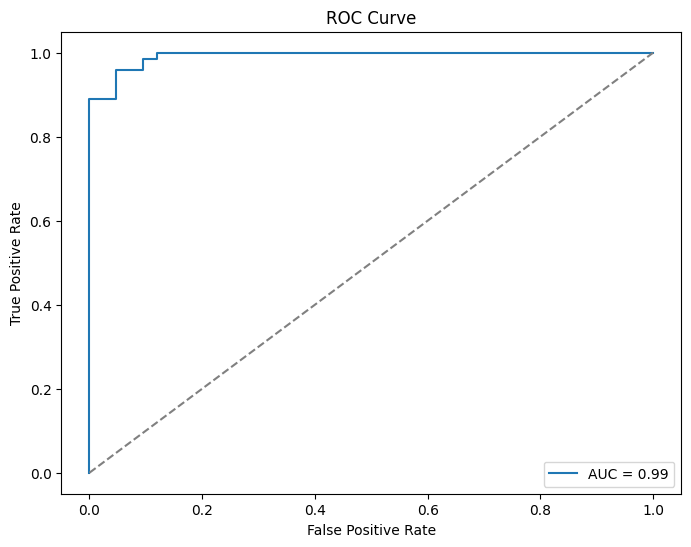

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Multi Class

- The shape of the output from `predict_proba()` becomes `(n_samples, n_classes)`.
- Each column corresponds to the probability of a sample belonging to a particular class.
- You need to specify which class you're calculating the ROC curve for — usually done using **one-vs-rest (OvR)** or **one-vs-one (OvO)** strategies.

For example, if you have 3 classes (0, 1, 2), and we want to get probabilities for class 2:

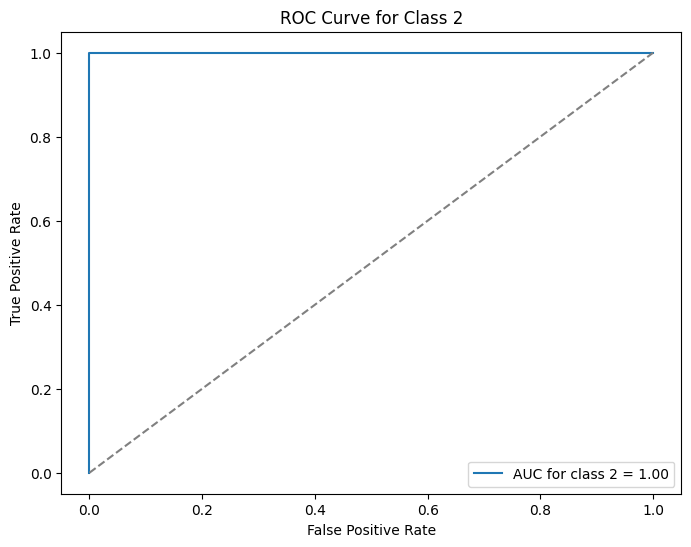

In [22]:
X, y = load_iris(return_X_y=True, as_frame=True)
rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

lr = LogisticRegression()
lr.fit(X_train, y_train)
# Get probabilities for class 2
y_proba = lr.predict_proba(X_test)[:, 2]

# Compute ROC curve for class 2 (using one-vs-rest)
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=2)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC for class 2 = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 2')
plt.legend()
plt.show()

# Pipeline Template

In [23]:
# template for Pipeline. Edit column transformer variable to edit the data columns needed; edit 'model' step in pipeline to be whichever estimator needed

rng = np.random.RandomState(0)

# make_column_transformer takes Tuples of the form (transformer, columns); columns take [] if transformer expects 2D array, no brackets if it expects 1D array
column_transformer = make_column_transformer([
    (StandardScaler(), ['column name']),
    (OneHotEncoder(), ['column name'])],
    n_jobs=-1)

# name of step, estimator
pipeline = Pipeline([
    ('column transformer', column_transformer),
    ('imputer',SimpleImputer()),
    ('feature reduction', PCA()),
    ('model', SGDClassifier())
])

# parameter grid for GridSearchCV
param_grid = {

}

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rng)

grid = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=5,
                    return_train_score=True
                    )



---
---

# Quick Notes

- Never call fit() on test data
- sklearn.preprocessing